# Create paper emulation figure


In [7]:
import os
import numpy as np
## Ignore my broken HDF5 install|...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss/1000000000  # Return resident set size in bytes


In [2]:
import iris
from utils import get_bc_ppe_data
import psutil
from esem import gp_model
from esem.utils import get_random_params
import seaborn
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import xarray as xr
os.chdir('/home/ybhatti/yusufb/Scripts/PhD_Scripts/')
from my_functions import *
os.chdir('/home/ybhatti/prjs1076/ESEm')
from esem import cnn_model
from utils import normalize
os.chdir('/home/ybhatti/prjs1076/Emulator')
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import gc

print(f"Memory usage: {get_memory_usage()} GB")

dms_ppt=(29/62.13)*1e12/1000 # molecular mass of air (g/mol). molecular mass of DMS (g/mol).
dms_ppb=(29/62.13)*1e11/1000 # molecular mass of air (g/mol). molecular mass of DMS (g/mol).

h2so4_mmr=1e14/1000
h2so4_aod=1e15/1000
so2_ppb=(29/64.066)*1e11/1000 # ppb
so2_ppt=(29/64.066)*1e12/1000 # ppb
oh_ppt=(29/17.008)*1e12/1000 # ppb
no3_ppt=(29/62.0049)*1e12/1000 # ppb
o3_ppt=(29/48)*1e12/1000 # ppb
cl_ppt=(29/35.453)*1e12/1000 # ppb
h2so4_ppt=(29/98.079)*1e12/1000 # ppb
h2so4_ppm=(29/98.079)*1e10/1000 # ppb


2024-09-30 14:41:52.931672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:41:54.307891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:41:54.379335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 14:41:54.758191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 14:41:54.765715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 14:41:55.697945: I tensorflow/core/platform/cpu_feature_gu

Memory usage: 0.51054592 GB


## Read in the parameters and data

In [121]:
# variable='rad'
# files = [f"/home/ybhatti/prjs1076/PPE_Output/PI_PPE_Experiments/PPE_ENS_{i}/PPE_ENS_{i}_185*.01_{variable}.nc"
#          for i in np.concatenate((np.arange(118, 131),
#                                   np.arange(151, 162),
#                                   np.arange(174, 181)))]

# datasets = [xr.open_mfdataset(f, combine='by_coords') for f in files]
# lats=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lat
# lons=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lon
# # Combine datasets along a new 'ensemble' dimension
# combined_data = xr.concat(datasets, dim='ensemble')
# # Assign ensemble numbers to the new dimension
# combined_data['ensemble'] = np.concatenate((np.arange(118, 131), np.arange(151, 162), np.arange(174, 181)))

# # Group by the 'month' coordinate from 'time' and compute the mean for each month
# result = combined_data.DMS.mean('time').load()
# #aod = result.TAU_2D_550nm.mean('time')
# dms=areaweight(result[:,46]*dms_ppt*1000,result.lat)
# print(f"Memory usage: {get_memory_usage()} GB")


Memory usage: 34.322358272 GB


In [3]:
lats=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lat
lons=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lon


AOD_PI=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').TAU_2D_550nm

#CDNC_PI=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/cdnc_PPE.nc').CDNC
RF_PI=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/RF_PPE.nc').srad0

#aod_modes_PI=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_modes_PPE.nc')

# sum_tau_modes = (
#     aod_modes_PI['TAU_MODE_KS_550nm'] +
#     aod_modes_PI['TAU_MODE_AS_550nm'] +
#     aod_modes_PI['TAU_MODE_CS_550nm'] +
#     aod_modes_PI['TAU_MODE_KI_550nm'] +
#     aod_modes_PI['TAU_MODE_AI_550nm'] +
#     aod_modes_PI['TAU_MODE_CI_550nm']
# )



#For when there are 13 time slices instead of 12 (pre-processing step)
# aod_modes_PI_dropped = xr.concat(
#     [aod_modes_PI.isel(time=slice(0, 11)), aod_modes_PI.isel(time=slice(12, None))],
#     dim='time'
# )


In [7]:
## Plot initial Results of aod

variables=['TAU_MODE_KS_550nm',
'TAU_MODE_KI_550nm',
'TAU_MODE_AS_550nm',
'TAU_MODE_AI_550nm',
'TAU_MODE_CS_550nm',
'TAU_MODE_CI_550nm']
data=[]
for v in (variables):
    mean=areaweight(aod_modes_PI[v],lats).mean('time')
    data.append(mean)

combined = xr.concat(data, dim="modes").sortby('ensemble')
mean_aod_modes = combined[:,1:].mean(dim='ensemble')
std_aod_modes = combined[:,1:].std(dim='ensemble')


Mean AOD: 0.12549300107871236
Standard Deviation: 0.025211272616561614


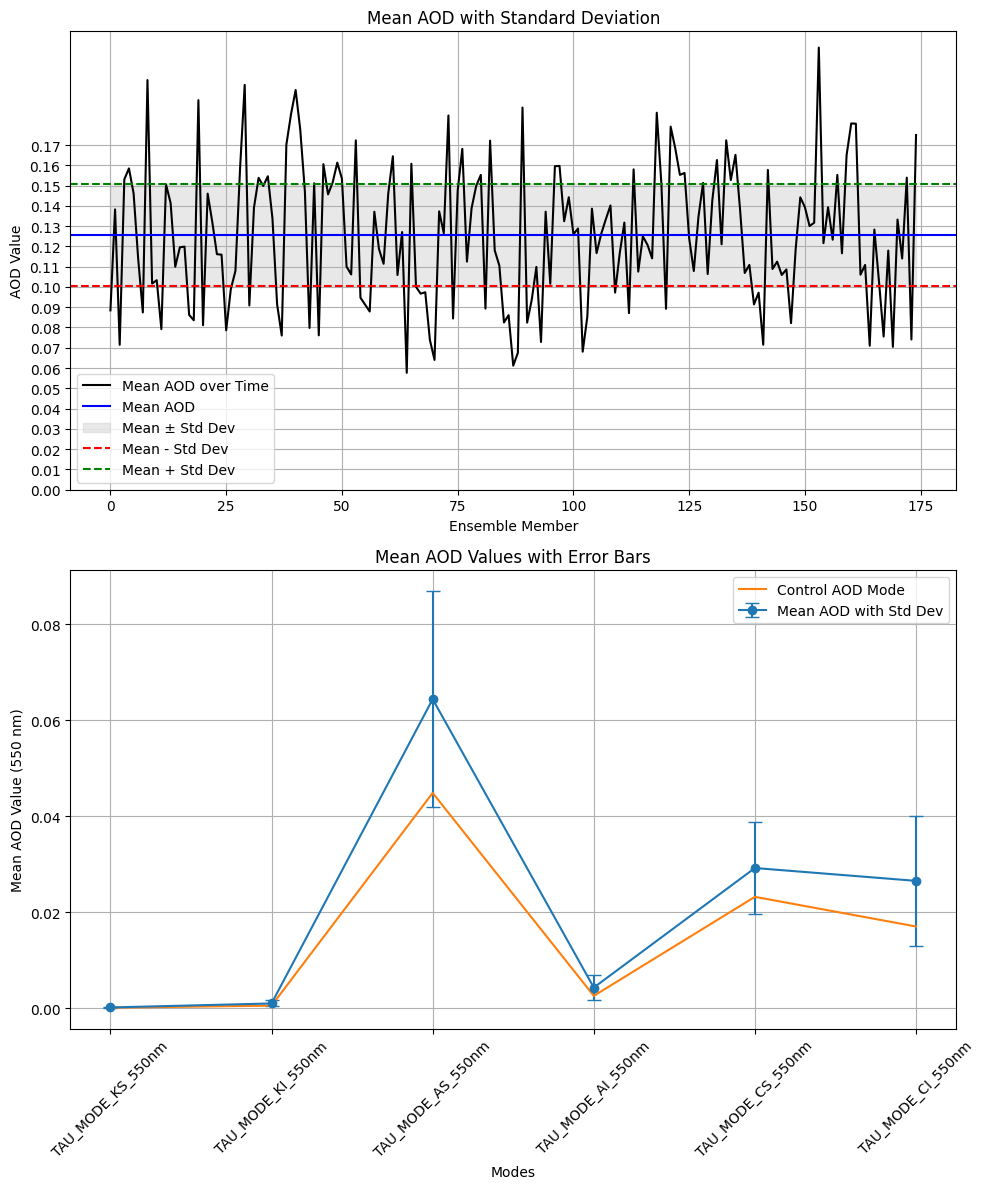

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Assuming AOD_PI and lats are already defined and contain the relevant data
mean_aod = areaweight(AOD_PI, lats).mean('time').mean(dim='ensemble')  # Mean across ensemble
std_aod = areaweight(AOD_PI, lats).std('time').mean(dim='ensemble')    # Standard deviation across ensemble

# Check the values
print("Mean AOD:", mean_aod.item())
print("Standard Deviation:", std_aod.item())

# Define the variables for the x-axis of the second plot
variables = [
    'TAU_MODE_KS_550nm',
    'TAU_MODE_KI_550nm',
    'TAU_MODE_AS_550nm',
    'TAU_MODE_AI_550nm',
    'TAU_MODE_CS_550nm',
    'TAU_MODE_CI_550nm'
]

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# --- Top Plot: Mean AOD with Standard Deviation ---
# Plotting mean AOD over time
axs[0].plot(areaweight(AOD_PI, lats).mean('time'), label='Mean AOD over Time', color='black')

# Mean value
mean_value = mean_aod.item()  # Get the scalar value
std_value = std_aod.item()    # Get the scalar value for standard deviation

# Plot a horizontal line at the mean value
axs[0].axhline(mean_value, color='blue', linestyle='-', label='Mean AOD')

# Shade the area for mean ± std
axs[0].fill_between(
    range(areaweight(AOD_PI, lats).shape[0]),  # Extend over the x-coordinates of the data
    mean_value - std_value,                    # Lower bound
    mean_value + std_value,                    # Upper bound
    color='lightgray',                         # Shaded color
    alpha=0.5,                                # Transparency
    label='Mean ± Std Dev'
)

# Adding titles and labels
axs[0].set_title('Mean AOD with Standard Deviation')
axs[0].set_ylabel('AOD Value')
axs[0].set_xlabel('Ensemble Member')
axs[0].set_yticks(np.arange(0, mean_value + 2*std_value, 0.01))  # Adjust as needed based on your data
axs[0].axhline(mean_value - std_value, color='red', linestyle='--', label='Mean - Std Dev')
axs[0].axhline(mean_value + std_value, color='green', linestyle='--', label='Mean + Std Dev')
axs[0].legend()
axs[0].grid(True)

# --- Bottom Plot: Mean AOD Values with Error Bars ---
# Create the line plot for mean AOD with error bars
axs[1].errorbar(
    range(mean_aod_modes.size),      # x (modes)
    mean_aod_modes.values,          # y (mean values)
    yerr=std_aod_modes.values,      # error (standard deviation)
    fmt='o-',                  # style
    capsize=5,                 # Cap size for error bars
    label='Mean AOD with Std Dev'
)
plt.plot(
    range(combined[:,0].size),  # x (modes)
    combined[:,0].values,      # y (mean values)
    label='Control AOD Mode'
)


# Adding titles and labels
axs[1].set_title('Mean AOD Values with Error Bars')
axs[1].set_xlabel('Modes')
axs[1].set_ylabel('Mean AOD Value (550 nm)')
axs[1].set_xticks(ticks=range(mean_aod_modes.size))
axs[1].set_xticklabels(variables, rotation=45)
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [39]:
ppe_params = pd.read_csv('/home/ybhatti/prjs1076/Emulator/Tester/PPE_values.csv')[:]
ppe_params.set_index(ppe_params.columns[0], inplace=True)

#valid_params = ppe_params[ppe_params.index.isin([f'PPE_ENS_{ens}' for ens in valid_ensembles])]

#ppe_params = pd.read_csv('/home/ybhatti/prjs1076/Emulator/Tester/PPE_values.csv')[:39]
control = xr.open_dataset('/home/ybhatti/prjs1076/Emulator/Tester/AOD_Ensembles_Tester.nc').TAU_2D_550nm[0]
ppe_aod = xr.open_dataset('/home/ybhatti/prjs1076/Emulator/Tester/AOD_Ensembles_Tester.nc').TAU_2D_550nm[:150]#[:-1]#.mean('time')[:-1]
lats=ppe_aod.lat
lons=ppe_aod.lon
# lats=xr.open_dataset('/home/ybhatti/prjs1076/PPE_Output/PPE_Experiments/PPE_ENS_Control/PPE_ENS_Control_200907.12_ham.nc').lat
# lons=xr.open_dataset('/home/ybhatti/prjs1076/PPE_Output/PPE_Experiments/PPE_ENS_Control/PPE_ENS_Control_200907.12_ham.nc').lon
ppe_param = ppe_params.iloc[:150, :]
n_test = 40
# ppe_aod = ppe_aod.to_iris()
# ppe_aod.transpose((0,2,3,1))
#ppe_aod=ppe_aod.transpose('ensemble','lat','lon','time').mean('time')
#These scaling parameters are log-uniformly distributed


ppe_paramater = np.log(ppe_param)
ppe_para = ppe_paramater.apply(normalize, axis=0)


In [10]:
ppe_params = pd.read_csv('~/yusufb/Branches/PPE_Scripts/parameter_values_data/PPE_values.csv')[:]

valid_ensembles = AOD_PI['ensemble'].values  # Get ensemble values from AOD_PI
valid_ensembles = valid_ensembles[valid_ensembles != 0]  # Exclude control ensemble (0)

ppe_params.set_index(ppe_params.columns[0], inplace=True)
valid_params = ppe_params[ppe_params.index.isin([f'PPE_ENS_{ens}' for ens in valid_ensembles])]

# Create the new row with all columns set to 1, and update specific values
new_row = {col: 1 for col in valid_params.columns}
new_row.update({
    'V_SCALE_BC_RAD_NI': 0.71,
    'V_SCALE_DU_RAD_NI': 0.001,
    'V_SCALE_PH_PERT': 2.5e-06,
    'V_SCALE_CDNC_MIN': 40,
    'V_SCALE_KAPPA_SO4': 0.6

})

# Create a DataFrame for the new row
new_row_df = pd.DataFrame([new_row], index=['PPE_Control'])

# Concatenate the new row DataFrame with the original DataFrame
ppe_params = pd.concat([new_row_df, valid_params])

ppe_paramater = np.log(ppe_params)
ppe_para = ppe_paramater.apply(normalize, axis=0)



In [11]:
#PPE = areaweight(AOD_PI[:].mean('time'),lats)
ppe_aod=RF_PI[:].mean('time')
n_test=40
X_test, X_train = ppe_para[:n_test], ppe_para[n_test:]
Y_test, Y_train = ppe_aod[:n_test], ppe_aod[n_test:]
print(f"Memory usage: {get_memory_usage()} GB")
gc.collect()

Memory usage: 0.598581248 GB


1432

In [ ]:
# Example DataFrame setup
# para = pd.read_csv('your_data.csv')  # Load your actual data
para = ppe_params
# Calculate min and max for each parameter
min_values = para.min()
max_values = para.max()

# Extract the PPE_Control values
ppe_control_values = para.loc['PPE_Control']

# Sort parameters by PPE_Control values in descending order
sorted_params = ppe_control_values.sort_values(ascending=False).index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Set the x-axis to log scale
ax.set_xscale('log')

# Loop through each parameter to plot the range and PPE_Control value
for i, param in enumerate(sorted_params):
    # Plot the horizontal line for min-max range
    ax.plot([min_values[param], max_values[param]], [i, i], color='blue', lw=2)  
    
    # Vertical lines at min and max
    ax.plot(min_values[param], i, 'k|', markersize=10)  
    ax.plot(max_values[param], i, 'k|', markersize=10)  
    
    # Plot 'x' marker for PPE_Control value
    ax.plot(ppe_control_values[param], i, 'rx', markersize=10)  

# Plot the vertical line connecting all 'x' markers
ax.plot(ppe_control_values[sorted_params], range(len(sorted_params)), 'r-', lw=2)

# Set y-ticks to be the parameter names
ax.set_yticks(range(len(sorted_params)))
ax.set_yticklabels(sorted_params)

# Add labels and title
ax.set_xlabel('Parameter Values')
ax.set_title('Parameter Ranges with Control Values')

# Invert the y-axis to match the order
ax.invert_yaxis()

# Add grid
ax.grid(True, which='both', ls='--', color='gray')

plt.show()


In [ ]:
# %reload_ext memory_profiler
# # This is just to make the control run give a proper value to the false ones
# ppe_param.iloc[-1, :]['V_SCALE_EMI_CMR_BF'] = 0.6096329008613072
# ppe_param.iloc[-1, :]['V_SCALE_EMI_CMR_FF'] = 0.5880197245007559
# ppe_param.iloc[-1, :]['V_SCALE_EMI_CMR_BB'] = 0.6081
# ppe_param.iloc[-1, :]['V_SCALE_KAPPA_SO4'] = 0.5545352759103607
# ppe_param.iloc[-1, :]['V_SCALE_BC_RAD_NI'] = 0.621700989293994




peak memory: 83650.64 MiB, increment: 29.41 MiB


## Setup and run the models

In [12]:
nn_model = cnn_model(X_train, Y_train)

# Then use the magic command to profile a function
print(f"Memory usage: {get_memory_usage()} GB")


Memory usage: 0.674107392 GB


/scratch-local/ybhatti.7959106/ipykernel_2003042/1061048300.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nn_model = cnn_model(X_train, Y_train)
2024-09-25 11:22:21.630948: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/ybhatti/yusufb/miniconda3/envs/ESM/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [13]:
nn_model.model.model.summary()
print(f"Memory usage: {get_memory_usage()} GB")


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 221184)         │     5,750,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 96, 192, 12)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 96, 192, 12)    │         2,172 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 96, 192, 1)     │           181 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,753,137 (21.95 MB)

 Trainable params: 5,753,137 (21.95 MB)

 Non-trainable params: 0 (0.00 B)

Memory usage: 0.674107392 GB


In [14]:
%%time
nn_model.train()
print(f"Memory usage: {get_memory_usage()} GB")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.9895 - val_loss: 0.9872
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.0501 - val_loss: 0.9867
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.0428 - val_loss: 0.9864
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.0458 - val_loss: 0.9865
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.0272 - val_loss: 0.9859
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.0308 - val_loss: 0.9854
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.0672 - val_loss: 0.9875
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.9985 - val_loss: 0.9862
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.9905 - val_loss: 0.9768
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.9818 - val_loss: 0.9623
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.0417 - val_loss: 0.9313
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

In [ ]:
## Linear model:  0.3566 - val_loss: 0.0867gp_prediction

In [15]:
nn_prediction, _ = nn_model.predict(X_test.values)

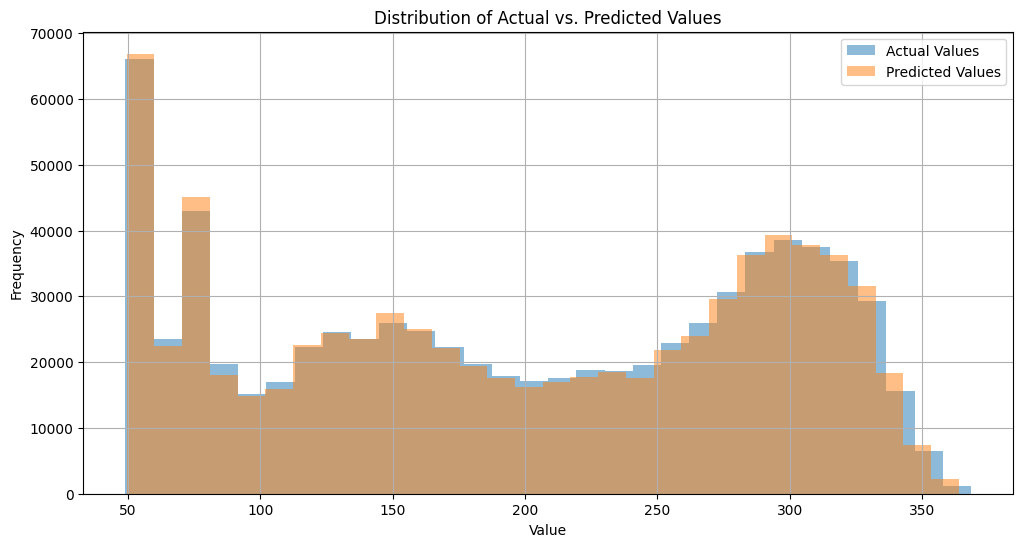

In [16]:
# Plot distributions
plt.figure(figsize=(12, 6))
plt.hist(Y_test.data.flatten(), bins=30, alpha=0.5, label='Actual Values')
plt.hist(nn_prediction.data.flatten(), bins=30, alpha=0.5, label='Predicted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
gp_model_ = gp_model(X_train, Y_train, kernel=['Bias', 'Linear'])
gp_model_.train()
print(f"Memory usage: {get_memory_usage()} GB")


Memory usage: 1.900826624 GB


In [18]:
gp_prediction, _ = gp_model_.predict(X_test.values)

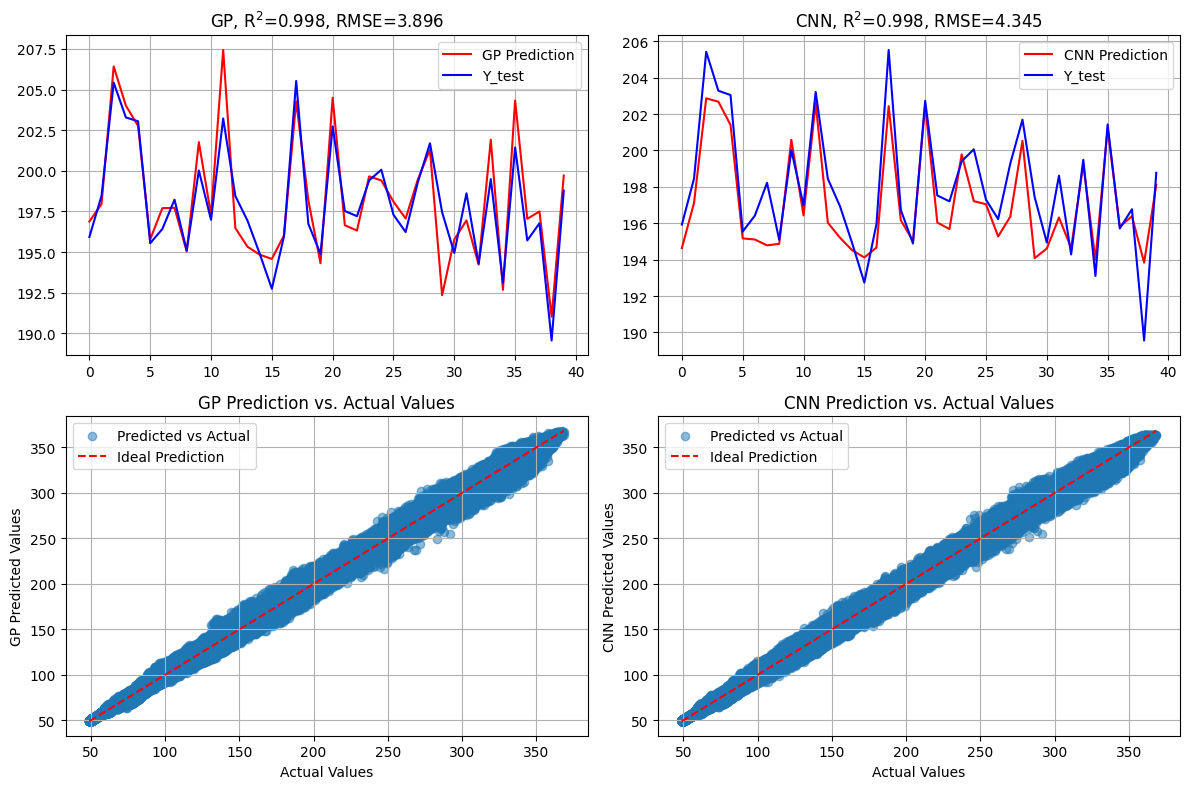

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
from math import sqrt
from sklearn.metrics import mean_squared_error

# Line plots
for ax, pred, title in zip(axs[0], [gp_prediction, nn_prediction], ['GP', 'CNN']):
    rmse_lines = sqrt(mean_squared_error(pred.data.flatten(),Y_test.data.flatten()))
    bias_lines = areaweight(pred,lats).mean() - areaweight(Y_test,lats).mean()
    r2_lines = np.corrcoef(pred.data.flatten(), Y_test.data.flatten())[1][0]**2

    ax.plot(pred.mean(['lat','lon']), color='red', label=f'{title} Prediction')
    ax.plot(Y_test.mean(['lat','lon']), color='blue', label='Y_test')
    ax.set_title(f"{title}, R$^{2}$={r2_lines:.3f}, RMSE={rmse_lines:.3f}")
    ax.legend()
    ax.grid(True)

# Scatter plots
for ax, pred, title in zip(axs[1], [gp_prediction, nn_prediction], ['GP', 'CNN']):
    min_val, max_val = min(np.min(Y_test), np.min(pred)), max(np.max(Y_test), np.max(pred))
    ax.scatter(Y_test, pred, alpha=0.5, label='Predicted vs Actual')
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel(f'{title} Predicted Values')
    ax.set_title(f'{title} Prediction vs. Actual Values')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Proportion of 'Bad' estimates : 7.05%


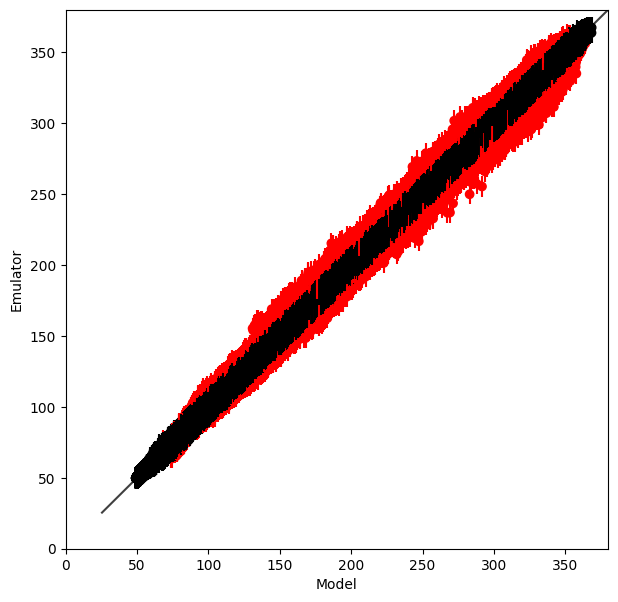

In [30]:
from esem.utils import validation_plot, plot_parameter_space, get_random_params, ensemble_collocate
validation_plot(Y_test.data.flatten(), gp_prediction.data.flatten(), _.data.flatten(),
               minx=0, maxx=380, miny=0., maxy=380)



In [ ]:
# # Create a new Cube with the transformed data
# Y_test_log = iris.cube.Cube(np.log10(Y_test[0].data), dim_coords_and_dims=[(coord, i) for i, coord in enumerate(Y_test[0].dim_coords)]) 
# gp_prediction_log = iris.cube.Cube(np.log10(gp_prediction[0].data), dim_coords_and_dims=[(coord, i) for i, coord in enumerate(gp_prediction[0].dim_coords)]) 
# nn_prediction_log = iris.cube.Cube(np.log10(nn_prediction[0].data), dim_coords_and_dims=[(coord, i) for i, coord in enumerate(nn_prediction[0].dim_coords)]) 



# # # Plotting
# # plt.figure(figsize=(10, 5))
# # plt.subplot(2, 3, 1, projection=ccrs.Mollweide())
# # plt.annotate("(a)", (0., 1.), xycoords='axes fraction')

# # # Plot the log-transformed Cube using iplt
# # iplt.pcolormesh(log_cube, vmin=-4, vmax=-1)
# # plt.gca().set_title('Truth')
# # plt.gca().coastlines()
# # plt.show()


In [20]:
# Function to create map plots
def plot_map(ax, data, xa, ya, cmap, levels=None, title=None):
    map_ax = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85, projection='cyl', resolution='c', ax=ax)
    x, y = map_ax(xa, ya)
    map_ax.drawcoastlines()
    map_ax.drawcountries()
    map_ax.drawmeridians(np.arange(0., 360, 60.), labels=[0, 0, 0, 1], fontsize=8)
    map_ax.drawparallels(np.arange(-90., 90, 30.), labels=[1, 0, 0, 0], fontsize=8)
    if levels is not None:
        cs = map_ax.contourf(x, y, data, levels, extend='both', cmap=cmap)
    else:
        cs = map_ax.contourf(x, y, data, extend='both', cmap=cmap)
    if title:
        ax.set_title(title, fontsize=14)
    return cs



In [21]:
#new_samples = pd.DataFrame(0, index=range(n), columns=ppe_param.columns)
# Extract the PPE_Control row as a Series

def PPE_Uncertainty(n,VARIABLE,ppe_control_values):    
        #data = new_samples
    # Create a new DataFrame with `n` rows, where each row is filled with the `PPE_Control` values
    new_samples = pd.DataFrame([ppe_control_values] * n, index=range(n))

    new_samples[VARIABLE] = np.random.uniform(0, 1, n)  # V_SCALE_EMI_SS with values between 0.5 and 2.5
    # new_samples['V_SCALE_EMI_SSA'] = 0.71
    # new_samples['V_SCALE_BC_RAD_NI'] = 0.001
    # new_samples['V_SCALE_PH_PERT'] =2.5e-06
    # new_samples['V_SCALE_DU_RAD_NI'] = 0.001
    
    #mo, _ = nn_model.predict(new_samples.values)
    # Zs = m.data
    m, sd = gp_model_.batch_stats(new_samples, batch_size=n)
    mnn, sdnn = nn_model.batch_stats(new_samples, batch_size=n)
    print(f"Memory usage: {get_memory_usage()} GB")
    
    print(f"Memory usage: {get_memory_usage()} GB")
    gc.collect()
    return m ,sd, mnn, sdnn

In [226]:
# sd = mo.std(['sample'])#.mean(['time'])
# m = mo.mean(['sample'])#.mean(['time'])
# diff = m.data-control.mean(['time'])
# print(f'std = {areaweight(sd,lats).data}')
# print(f'mea = {areaweight(m,lats).data}')
# print(f"Con = {areaweight(control.mean(['time']),lats).data}")
# print(f'dif = {areaweight(diff,lats).data}')
# print(f"Memory usage: {get_memory_usage()} GB")


In [23]:
Variable='V_SCALE_EMI_SSA'
mss, sdss, mnnss, sdnnss = PPE_Uncertainty(1000,Variable,ppe_control_values)


  0%|          | 0/1000 [00:00<?, ?sample/s]

  0%|          | 0/1000 [00:00<?, ?sample/s]

<tqdm.auto.tqdm object at 0x1461076cf2d0>Memory usage: 1.50949888 GB
Memory usage: 1.50949888 GB


  0%|          | 0/1000 [00:00<?, ?sample/s]

<tqdm.auto.tqdm object at 0x146107149d90>WARNING:tensorflow:5 out of the last 5 calls to <function _tf_stats at 0x146308fda700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


  0%|          | 0/1000 [00:00<?, ?sample/s]

<tqdm.auto.tqdm object at 0x1461077fc190>WARNING:tensorflow:6 out of the last 6 calls to <function _tf_stats at 0x146308fda700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Memory usage: 1.595183104 GB
Memory usage: 1.595183104 GB


/scratch-local/ybhatti.7959106/ipykernel_2003042/1135030181.py:22: RuntimeWarning: divide by zero encountered in divide
  rel_per_diff=(((sd.data / m.data) / (sdnn.data / mnn.data))-1) * 100


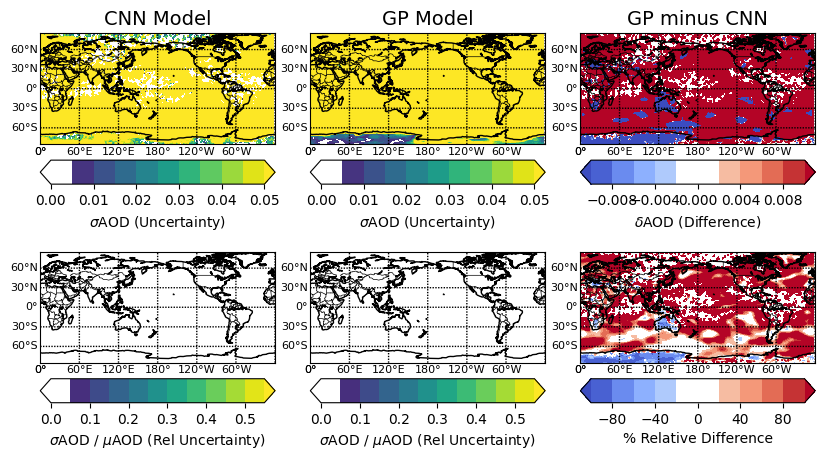

In [24]:
Variable='V_SCALE_EMI_DMS'

fig, axs = plt.subplots(2, 3, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1], 'hspace': -0.45, 'wspace': 0.15})
clevs = [np.arange(0, 0.05 + 0.005, 0.005),
         np.arange(0, 0.05 + 0.005, 0.005),
         np.arange(-0.01, 0.01 + 0.002, 0.002)]

rel_clevs = [np.arange(0, 0.6, 0.05),
             np.arange(0, 0.6, 0.05),
             np.arange(-100, 100 + 20, 20)]
coolwarm_dataset = plt.cm.viridis(np.linspace(0, 1, 128))
coolwarm_dataset[0:16, :] = 1.0  # Set center values as white
coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_dataset)
coolwarm_dataset_middle = plt.cm.coolwarm(np.linspace(0, 1, 128))
coolwarm_dataset_middle[56:72, :] = 1.0  # Set center values as white
coolwarm_whites_middle = LinearSegmentedColormap.from_list('coolwarm', coolwarm_dataset_middle)


ppe_control_values = ppe_para.loc['PPE_Control']
m, sd, mnn, sdnn = PPE_Uncertainty(1000,Variable,ppe_control_values)

rel_per_diff=(((sd.data / m.data) / (sdnn.data / mnn.data))-1) * 100
xa, ya = np.meshgrid(lons, lats)
data_top = [sdnn.data, sd.data, sd.data - sdnn.data]
data_bot = [sdnn.data / mnn.data, sd.data / m.data, rel_per_diff ]
titles = ['CNN Model', 'GP Model','GP minus CNN']


# Plot absolute uncertainties (std) in the top row
cs1 = [plot_map(axs[0, i], data_top[i], xa, ya, coolwarm_whites,clevs[i], titles[i]) for i in range(2)]
cs1 += [plot_map(axs[0, i], data_top[i], xa, ya, coolwarm_whites_middle,clevs[i], titles[i]) for i in range(2,3)]

# Plot relative uncertainties (std/mean) in the bottom row
cs2 = [plot_map(axs[1, i], data_bot[i], xa, ya, coolwarm_whites,rel_clevs[i]) for i in range(2)]
cs2 += [plot_map(axs[1, i], data_bot[i], xa, ya, coolwarm_whites_middle,rel_clevs[i]) for i in range(2,3)]

# Plot the DIFFERENCES between CNN and GP

labels= [f'$\sigma$AOD (Uncertainty)', f'$\sigma$AOD (Uncertainty)', f'$\delta$AOD (Difference)']
rel_labels=[f'$\sigma$AOD / $\mu$AOD (Rel Uncertainty)',f'$\sigma$AOD / $\mu$AOD (Rel Uncertainty)', '% Relative Difference']
for i in range(3):
    # Color bar for absolute uncertainties (std)
    cax1 = fig.add_axes([axs[0, i].get_position().x0, axs[0, i].get_position().y0 - 0.05, axs[0, i].get_position().width, 0.03])
    fig.colorbar(cs1[i], cax=cax1, extend='both', orientation='horizontal').set_label(labels[i], fontsize=10)

    # Color bar for relative uncertainties (std/mean)
    cax2 = fig.add_axes([axs[1, i].get_position().x0, axs[1, i].get_position().y0 - 0.05, axs[1, i].get_position().width, 0.03])
    fig.colorbar(cs2[i], cax=cax2, extend='both', orientation='horizontal').set_label(rel_labels[i], fontsize=10)

# # Adding colorbars at the bottom
# cax1 = fig.add_axes([0.11, 0.1, 0.38, 0.02])
# fig.colorbar(cs1[0], cax=cax1, extend='both', orientation='horizontal').set_label(f'$\sigma$AOD', fontsize=12)

# cax2 = fig.add_axes([0.11 + 0.425, 0.1, 0.38, 0.02])|
# fig.colorbar(cs2[1], cax=cax2, extend='both', orientation='horizontal').set_label(f'$\sigma$AOD / $\mu$AOD', fontsize=12)
